# [PetFinder.my - Pawpularity Contest](https://www.kaggle.com/c/petfinder-pawpularity-score)
> Predict the popularity of shelter pet photos

![](https://storage.googleapis.com/kaggle-competitions/kaggle/25383/logos/header.png)

# Idea:
* Use **Classification** instead of **Regression**.
    * Normalize `Pawpularity` from `[0,100]` range to `[0,1]`.
    * Use `BinaryCrossentropy` loss intead of `RootMeanSquaredError`
    * Calculate competition metric after **denormalizing** the prediction
* Use **Transformer** instead of **CNN**
* Use only **Image** Feature.
* **Wandb** is integrated hence we can use this notebook to track which experiemnt is peforming better and also do error analysis using **Attenion-MAP** at the end.


# Notebooks:
* Only Image:
    * CNN:
        * train: [[TF] PetFinder: Image [TPU][Train] 🐶](https://www.kaggle.com/awsaf49/tf-petfinder-image-tpu-train)
        * infer: [[TF] PetFinder: Image [TPU][Infer] 🐶](https://www.kaggle.com/awsaf49/tf-petfinder-image-tpu-infer)
    * Transformer + Classification:
        * train: [[TF] PetFinder: ViT+Cls [TPU][Train] 😺](https://www.kaggle.com/awsaf49/tf-petfinder-vit-cls-tpu-train/edit)
* Image+Tabular:
    * CNN:
        * train: [[TF] PetFinder: Image+Tabular [TPU][Train] 🐶](https://www.kaggle.com/awsaf49/tf-petfinder-image-tabular-tpu-train)


# Overview:

## Augmentations:
* Random - Horizontal Flip
* Random - Brightness, Contrast, Hue, Saturation
* Coarse Dropout

<img src="https://i.ibb.co/XC4dBJs/results-39-0.png" alt="results-39-0" border="0">

## WandB Integration:
* You can track your training using **wandb**
* It's very easy to compare model's performance using **wandb**.

<img src="https://i.ibb.co/KKxF8Fj/wandb-result.png" alt="wandb-result" border="0">

## Attention-MAP:
* You can use **Attention-MAP** to interpret the results

<img src="https://i.ibb.co/hCPQWsD/cvt.gif" alt="cvt" border="0">

## Train Vs OOF Distribution:

<img src="https://i.ibb.co/Yy4NXvW/results-58-0.png" alt="results-58-0" border="0">

# Content:
* Install Libraries.
* Import Libraries.
* Libraries Version Check
* Wandb
* Configuration.
* Set Seed for Reproducibility.
* TPU Configs.
* GCS Path for TPU.
* Meta Data.
* Train-Test Distrubution
* EDA
    * Train.
    * Test.
* Data Split.
* Data Augmentation.
* Data Pipeline.
* Visualization.
* Loss Function.
* Build Model.
* Learning-Rate Scheduler.
* Grad-CAM Helper
* Wandb Logger
* Train Model
* Calculate OOF Scorej
* Pawpularity Distrubtion of Train & OOF





# Install Libraries

In [1]:
!pip install -q efficientnet >> /dev/null
!pip install -q imagesize
!pip install -qU wandb
!pip install -q vit-keras

# Import Libraries

In [2]:
import pandas as pd, numpy as np, random,os, shutil
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
import sklearn
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import imagesize
import wandb
import yaml

from vit_keras import vit
from IPython import display as ipd
from glob import glob
from tqdm.notebook import tqdm
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score

2021-10-01 17:22:12.034808: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-01 17:22:12.034924: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Version Check

In [3]:
print('np:', np.__version__)
print('pd:', pd.__version__)
print('sklearn:', sklearn.__version__)
print('tf:',tf.__version__)
print('tfa:', tfa.__version__)
print('w&b:', wandb.__version__)

np: 1.19.5
pd: 1.3.2
sklearn: 0.23.2
tf: 2.4.1
tfa: 0.12.1
w&b: 0.12.3


# Wandb

<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67" width="400" alt="Weights & Biases" />

<span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;"> Weights & Biases (W&B) is MLOps platform for tracking our experiemnts. We can use it to Build better models faster with experiment tracking, dataset versioning, and model management</span>

<span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Some of the cool features of **W&B**:</span>

* <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Track, compare, and visualize ML experiments<br></span>
* <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Get live metrics, terminal logs, and system stats streamed to the centralized dashboard.<br></span>
* <span style="color: #000508; font-family: Segoe UI; font-size: 1.2em; font-weight: 300;">Explain how your model works, show graphs of how model versions improved, discuss bugs, and demonstrate progress towards milestones.<br></span>

In [4]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    wandb.login(key=api_key)
    anonymous = None
except:
    anonymous = "must"
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

To use your W&B account,
Go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. 
Get your W&B access token from here: https://wandb.ai/authorize


# Configuration

In [5]:
class CFG:
    wandb         = False
    competition   = 'petfinder' 
    _wandb_kernel = 'awsaf49'
    debug         = False
    exp_name      ='vit_b16+cls-baseline' # name of the experiment, folds will be grouped using 'exp_name'
    
    # USE verbose=0 for silent, vebose=1 for interactive, verbose=2 for commit
    verbose      = 1 if debug else 0
    display_plot = True

    device = "TPU" #or "GPU"

    model_name = 'vit_b16' # 'vit_b32'

    # USE DIFFERENT SEED FOR DIFFERENT STRATIFIED KFOLD
    seed = 42

    # NUMBER OF FOLDS. USE 2, 5, 10
    folds = 5
    
    # FOLDS TO TRAIN
    selected_folds = [0, 1, 2, 3, 4]

    # IMAGE SIZE
    img_size = [512, 512]

    # BATCH SIZE AND EPOCHS
    batch_size  = 32
    epochs      = 5

    # LOSS
    loss      = 'BCE'
    optimizer = 'Adam'

    # CFG.augmentATION
    augment   = True
    transform = False

    # TRANSFORMATION
    fill_mode = 'nearest'
    rot    = 10.0
    shr    = 5.0
    hzoom  = 30.0
    wzoom  = 30.0
    hshift = 30.0
    wshift = 30.0

    # FLIP
    hflip = True
    vflip = False

    # CLIP [0, 1]
    clip = False

    # LEARNING RATE SCHEDULER
    scheduler   = 'exp' # Cosine

    # Dropout
    drop_prob   = 0.75
    drop_cnt    = 10
    drop_size   = 0.05

    #bri, contrast
    sat  = [0.7, 1.3]
    cont = [0.8, 1.2]
    bri  =  0.15
    hue  = 0.05

    # TEST TIME CFG.augmentATION STEPS
    tta = 1
    
    tab_cols    = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
                   'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']
    target_col  = ['Pawpularity']

# Set Seed for Reproducibility

In [6]:
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
#     os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    tf.random.set_seed(SEED)
    print('seeding done!!!')
seeding(CFG.seed)

seeding done!!!


# TPU Configs

In [7]:
if CFG.device == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        CFG.device = "GPU"

if CFG.device != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if CFG.device == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...


2021-10-01 17:22:19.428186: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-01 17:22:19.431224: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-01 17:22:19.431265: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-01 17:22:19.431299: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9a8172fb1a3d): /proc/driver/nvidia/version does not exist
2021-10-01 17:22:19.435378: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

TPU initialized
REPLICAS: 8


# GCS Path for TPU
* TPU requires **GCS** path. Luckily Kaggle Provides that for us :)

In [8]:
BASE_PATH = '/kaggle/input/petfinder-pawpularity-score'
GCS_PATH  = KaggleDatasets().get_gcs_path('petfinder-pawpularity-score')

# Meta Data

In [9]:
def get_imgsize(row):
    width, height = imagesize.get(row['image_path'].replace(GCS_PATH, BASE_PATH))
    row['width']  = width
    row['height'] = height
    return row

In [10]:
# Train Data
df = pd.read_csv('../input/petfinder-pawpularity-score/train.csv')
df['image_path'] = GCS_PATH + '/train/' + df.Id + '.jpg'
tqdm.pandas(desc='train')
df = df.progress_apply(get_imgsize, axis=1)
display(df.head(2))

# Test Data
test_df  = pd.read_csv('../input/petfinder-pawpularity-score/test.csv')
test_df['image_path'] = GCS_PATH + '/test/' + test_df.Id + '.jpg'
tqdm.pandas(desc='test')
test_df = test_df.progress_apply(get_imgsize, axis=1)

display(test_df.head(2))

train:   0%|          | 0/9912 [00:00<?, ?it/s]

Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   

                                          image_path  width  height  
0  gs://kds-33983552a5f209f01fbbf92a10d2cf3053541...    405     720  
1  gs://kds-33983552a5f209f01fbbf92a10d2cf3053541...   1032     774

test:   0%|          | 0/8 [00:00<?, ?it/s]

Id  Subject Focus  Eyes  Face  Near  Action  \
0  4128bae22183829d2b5fea10effdb0c3              1     0     1     0       0   
1  43a2262d7738e3d420d453815151079e              0     1     0     0       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
0          1      1        0      0          1     0     1   
1          0      1        1      0          0     0     0   

                                          image_path  width  height  
0  gs://kds-33983552a5f209f01fbbf92a10d2cf3053541...    128     128  
1  gs://kds-33983552a5f209f01fbbf92a10d2cf3053541...    128     128

## Train-Test Ditribution

In [11]:
print('train_files:',df.shape[0])
print('test_files:',test_df.shape[0])

train_files: 9912
test_files: 8


# Light EDA
If you're too lazy to do **EDA** by yourself. Then definitely this library is for you. You can use **Pandas-Profiling** to do bunch of **EDA** with vey few lines of code. 😉

In [12]:
from pandas_profiling import ProfileReport
train_profile = ProfileReport(df, title="Train Data")
test_profile  = ProfileReport(test_df, title="Test Data")

## Train

In [13]:
display(train_profile)

Summarize dataset:   0%|          | 0/30 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Test

In [14]:
display(test_profile)

Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Data Split
* Data is splited using **Pawpularity** distrubtion.


In [15]:
num_bins = int(np.floor(1 + np.log2(len(df))))
df["bins"] = pd.cut(df[CFG.target_col].values.reshape(-1), bins=num_bins, labels=False)

skf = StratifiedKFold(n_splits=CFG.folds, shuffle=True, random_state=CFG.seed)
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df["bins"])):
    df.loc[val_idx, 'fold'] = fold
display(df.groupby(['fold', "bins"]).size())

fold  bins
0.0   0        66
      1        84
      2       221
      3       406
      4       376
             ... 
4.0   9        55
      10       40
      11       28
      12       21
      13       72
Length: 70, dtype: int64

# Data Augmentation
Used simple augmentations, some of them may hurt the model.
* RandomFlip (Left-Right)
* No Rotation
* RandomBrightness
* RndomContrast
* Shear
* Zoom
* Coarsee Dropout/Cutout

In [16]:
def get_mat(shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    #rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
#     c1   = tf.math.cos(rotation)
#     s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
#     rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
#                                    -s1,  c1,   zero, 
#                                    zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                               zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    

    return  K.dot(shear_matrix,K.dot(zoom_matrix, shift_matrix)) #K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))                  

def transform(image, DIM=CFG.img_size):#[rot,shr,h_zoom,w_zoom,h_shift,w_shift]):
    if DIM[0]!=DIM[1]:
        pad = (DIM[0]-DIM[1])//2
        image = tf.pad(image, [[0, 0], [pad, pad+1],[0, 0]])
        
    NEW_DIM = DIM[0]
    
    rot = CFG.rot * tf.random.normal([1], dtype='float32')
    shr = CFG.shr * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / CFG.hzoom
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / CFG.wzoom
    h_shift = CFG.hshift * tf.random.normal([1], dtype='float32') 
    w_shift = CFG.wshift * tf.random.normal([1], dtype='float32') 
    
    transformation_matrix=tf.linalg.inv(get_mat(shr,h_zoom,w_zoom,h_shift,w_shift))
    
    flat_tensor=tfa.image.transform_ops.matrices_to_flat_transforms(transformation_matrix)
    
    image=tfa.image.transform(image,flat_tensor, fill_mode=CFG.fill_mode)
    
    rotation = math.pi * rot / 180.
    
    image=tfa.image.rotate(image,-rotation, fill_mode=CFG.fill_mode)
    
    if DIM[0]!=DIM[1]:
        image=tf.reshape(image, [NEW_DIM, NEW_DIM,3])
        image = image[:, pad:DIM[1]+pad,:]
    image = tf.reshape(image, [*DIM, 3])    
    return image

def dropout(image,DIM=CFG.img_size, PROBABILITY = 0.6, CT = 5, SZ = 0.1):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image with CT squares of side size SZ*DIM removed
    
    # DO DROPOUT WITH PROBABILITY DEFINED ABOVE
    P = tf.cast( tf.random.uniform([],0,1)<PROBABILITY, tf.int32)
    if (P==0)|(CT==0)|(SZ==0): 
        return image
    
    for k in range(CT):
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM[1]),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM[0]),tf.int32)
        # COMPUTE SQUARE 
        WIDTH = tf.cast( SZ*min(DIM),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM[0],y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM[1],x+WIDTH//2)
        # DROPOUT IMAGE
        one = image[ya:yb,0:xa,:]
        two = tf.zeros([yb-ya,xb-xa,3], dtype = image.dtype) 
        three = image[ya:yb,xb:DIM[1],:]
        middle = tf.concat([one,two,three],axis=1)
        image = tf.concat([image[0:ya,:,:],middle,image[yb:DIM[0],:,:]],axis=0)
        image = tf.reshape(image,[*DIM,3])

#     image = tf.reshape(image,[*DIM,3])
    return image

## Data Pipeline
* Reads the raw file and then decodes it to tf.Tensor
* Resizes the image in desired size
* Chages the datatype to **float32**
* Caches the Data for boosting up the speed.
* Uses Augmentations to reduce overfitting and make model more robust.
* Finally, splits the data into batches.


In [17]:
def build_decoder(with_labels=True, target_size=CFG.img_size, ext='jpg'):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        if ext == 'png':
            img = tf.image.decode_png(file_bytes, channels=3)
        elif ext in ['jpg', 'jpeg']:
            img = tf.image.decode_jpeg(file_bytes, channels=3)
        else:
            raise ValueError("Image extension not supported")

        img = tf.image.resize(img, target_size)
        img = tf.cast(img, tf.float32) / 255.0
        img = tf.reshape(img, [*target_size, 3])

        return img
    
    def decode_with_labels(path, label):
        return decode(path), tf.cast(label, tf.float32)/100.0
    
    return decode_with_labels if with_labels else decode


def build_augmenter(with_labels=True, dim=CFG.img_size):
    def augment(img, dim=dim):
        img = transform(img,DIM=dim) if CFG.transform else img
        img = tf.image.random_flip_left_right(img) if CFG.hflip else img
        img = tf.image.random_flip_up_down(img) if CFG.vflip else img
        img = tf.image.random_hue(img, CFG.hue)
        img = tf.image.random_saturation(img, CFG.sat[0], CFG.sat[1])
        img = tf.image.random_contrast(img, CFG.cont[0], CFG.cont[1])
        img = tf.image.random_brightness(img, CFG.bri)
        img = dropout(img, DIM=dim, PROBABILITY = CFG.drop_prob, CT = CFG.drop_cnt, SZ = CFG.drop_size)
        img = tf.clip_by_value(img, 0, 1)  if CFG.clip else img         
        img = tf.reshape(img, [*dim, 3])
        return img
    
    def augment_with_labels(img, label):    
        return augment(img), label
    
    return augment_with_labels if with_labels else augment


def build_dataset(paths, labels=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.prefetch(AUTO)
    return ds

## Visualization
* Check if augmentation is working properly or not.

In [18]:
def display_batch(batch, size=2):
    imgs, tars = batch
    plt.figure(figsize=(size*5, 5))
    for img_idx in range(size):
        plt.subplot(1, size, img_idx+1)
        plt.title(f'{CFG.target_col[0]}: {tars[img_idx].numpy()[0]}', fontsize=15)
        plt.imshow(imgs[img_idx,:, :, :])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show() 

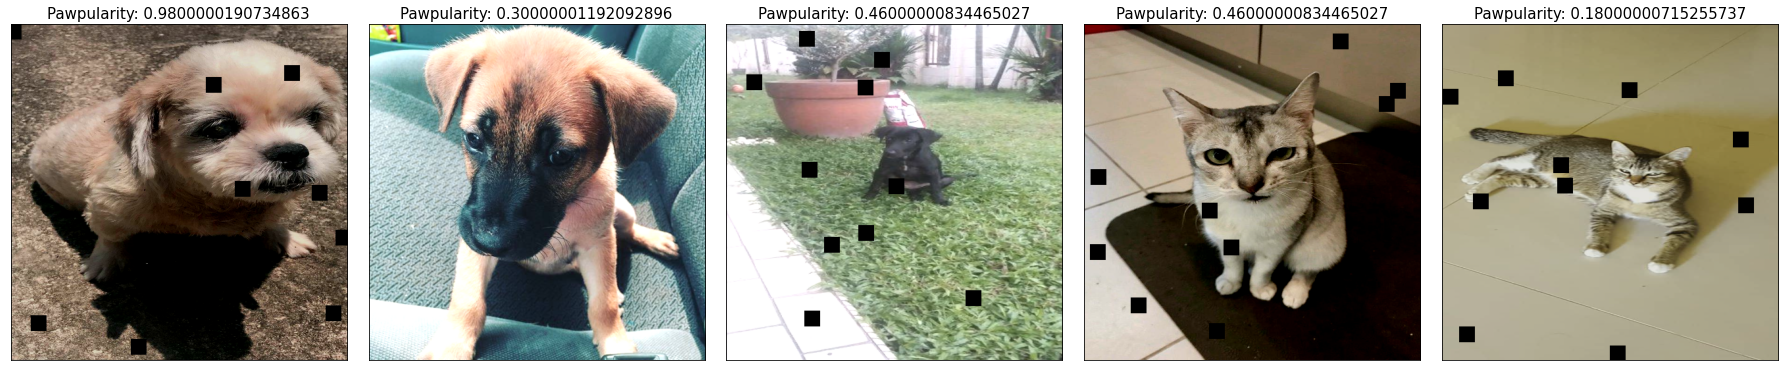

In [19]:
fold = 0
fold_df = df.query('fold==@fold')[:1000]
paths  = fold_df.image_path.tolist()
labels = fold_df[CFG.target_col].values
ds = build_dataset(paths, labels, cache=False, batch_size=CFG.batch_size*REPLICAS,
                   repeat=True, shuffle=True, augment=True)
ds = ds.unbatch().batch(20)
batch = next(iter(ds))
display_batch(batch, 5);

# Loss Function
Loss Function for this notebook is **BCE: Binary Crossentropy** as the task is converted form **regression** to **classification**
<!-- $$\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$ -->
$$\textrm{BCE}  = -\frac{1}{N} \sum_{i=1}^{N} y_i \cdot log(\hat{y}_i) + (1 - y_i) \cdot log(1 - \hat{y}_i)$$

where $\hat{y}_i$ is the **predicted** value and $y_i$ is the **original** value for each instance $i$.

* `tf.keras.losses.BinaryCrossentropy`

# Metric
Metric for this competition is **RMSE: Root Mean Squared Error**
$$\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$
where $\hat{y}_i$ is the **predicted** value and $y_i$ is the **original** value for each instance $i$.
* We have to denormalize our prediction to convert `[0-1]` range to `[0-100]` range
* Then we have to use **RMSE**

In [20]:
def RMSE(y_true, y_pred, denormalize=True):
    if denormalize:
        # denormalizing
        y_true = y_true*100.0
        y_pred = y_pred*100.0
    # rmse
    loss = tf.math.sqrt(tf.math.reduce_mean(tf.math.square(tf.subtract(y_true, y_pred))))
    return loss
RMSE.__name__='rmse'

# Build Model: 
## **Vision Transformer (ViT)**

[**How it works?**](https://analyticsindiamag.com/hands-on-vision-transformers-with-pytorch/)

Paper: [“An Image is Worth 16×16 Words: Transformers for Image Recognition at Scale”](https://arxiv.org/abs/2010.11929)

* ViT breaks an input image of 16×16 to a  sequence of patches, just like a series of word embeddings generated by an NLP Transformers. 
* Each patch gets flattened into a single vector in a series of interconnected channels of all pixels in a patch, then projects it to desired input dimension.
* Because transformers operate in self-attention mode, and they do not necessarily depend on the structure of the input elements, which in turns helps the architecture to learn and relate sparsely-distributed information more efficiently.
* The relationship between the patches in an image is not known and thus allows it to learn more relevant features from the training data and encode in positional embedding in ViT. 

<img src="https://lh5.googleusercontent.com/xk2mQd9H3w4uS482ursxhbDZhr7UXxJ9RMZ7VVjErBMuhbsB1QfSary9pOWU4P5EeZHmB05R8KalB5GXx__eCiN2AQ5qRhXY4vHwYe2zoFqIO0XkpHHXIE8VP99lpcgW5HtjPKKx" width="800">


In [21]:
import efficientnet.tfkeras as efn
from vit_keras import vit, utils, visualize, layers

name2effnet = {
    'efficientnet_b0': efn.EfficientNetB0,
    'efficientnet_b1': efn.EfficientNetB1,
    'efficientnet_b2': efn.EfficientNetB2,
    'efficientnet_b3': efn.EfficientNetB3,
    'efficientnet_b4': efn.EfficientNetB4,
    'efficientnet_b5': efn.EfficientNetB5,
    'efficientnet_b6': efn.EfficientNetB6,
    'efficientnet_b7': efn.EfficientNetB7,
}

def build_model(model_name=CFG.model_name, DIM=CFG.img_size[0], compile_model=True, include_top=False):       
#     base = name2effnet[model_name](input_shape=(DIM, DIM, 3),
#                                   include_top=include_top,
#                                    weights='imagenet',
#                                   )
    base = getattr(vit, model_name)(image_size=(DIM, DIM),
                   include_top=False, 
                   pretrained_top=False,
                   pretrained=True, 
                   weights='imagenet21k+imagenet2012')
    inp = base.inputs
    out = base.output
#     out = tf.keras.layers.GlobalAveragePooling2D()(out)
    out = tf.keras.layers.Dense(64,activation='selu')(out)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(out)
    model = tf.keras.Model(inputs=inp, outputs=out)
    if compile_model:
        #optimizer
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        #loss
        loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.01)
        #metric
        rmse = RMSE
        model.compile(optimizer=opt,
                      loss=loss,
                      metrics=[rmse])
    return model

## Model Check

In [22]:
tmp = build_model(CFG.model_name, DIM=CFG.img_size[0], compile_model=True)

347504640/347502902 [==============================] - 16s 0us/step


/opt/conda/lib/python3.7/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 32, 32
  UserWarning,


# Learning-Rate Scheduler

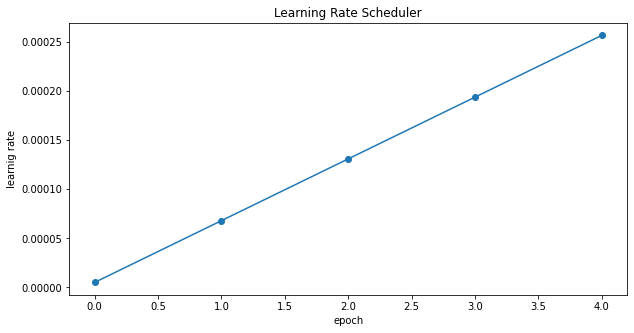

In [23]:
def get_lr_callback(batch_size=8, plot=False):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        elif CFG.scheduler=='exp':
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        elif CFG.scheduler=='cosine':
            decay_total_epochs = CFG.epochs - lr_ramp_ep - lr_sus_ep + 3
            decay_epoch_index = epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            cosine_decay = 0.5 * (1 + math.cos(phase))
            lr = (lr_max - lr_min) * cosine_decay + lr_min
        return lr
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(CFG.epochs), [lrfn(epoch) for epoch in np.arange(CFG.epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('learnig rate')
        plt.title('Learning Rate Scheduler')
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

_=get_lr_callback(CFG.batch_size, plot=True )

# Attention Map
* Attention map generated form **ViT** can  help you to interpret the result.

<img src="https://user-images.githubusercontent.com/6073256/101206904-2a338f00-36b3-11eb-8920-f617abab1604.png" width="800">

In [24]:
import matplotlib.cm as cm, cv2
from tensorflow import keras
from tensorflow.keras.preprocessing.image import array_to_img

def attention_map(model, image):
    """Get an attention map for an image and model using the technique
    described in Appendix D.7 in the paper (unofficial).
    Args:
        model: A ViT model
        image: An image for which we will compute the attention map.
    """
    size = model.input_shape[1]
    grid_size = int(np.sqrt(model.layers[5].output_shape[0][-2] - 1))

    # Prepare the input
    X = cv2.resize(image, (size, size))[np.newaxis, :]  # type: ignore

    # Get the attention weights from each transformer.
    outputs = [
        l.output[1] for l in model.layers if isinstance(l, layers.TransformerBlock)
    ]
    weights = np.array(
        tf.keras.models.Model(inputs=model.inputs, outputs=outputs).predict(X)
    )
    num_layers = weights.shape[0]
    num_heads = weights.shape[2]
    reshaped = weights.reshape(
        (num_layers, num_heads, grid_size ** 2 + 1, grid_size ** 2 + 1)
    )

    # From Appendix D.6 in the paper ...
    # Average the attention weights across all heads.
    reshaped = reshaped.mean(axis=1)

    # From Section 3 in https://arxiv.org/pdf/2005.00928.pdf ...
    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    reshaped = reshaped + np.eye(reshaped.shape[1])
    reshaped = reshaped / reshaped.sum(axis=(1, 2))[:, np.newaxis, np.newaxis]

    # Recursively multiply the weight matrices
    v = reshaped[-1]
    for n in range(1, len(reshaped)):
        v = np.matmul(v, reshaped[-1 - n])

    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size)
    mask = mask / mask.max()
    mask = np.uint8(255 * mask)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors  = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[mask]

    # Create an image with RGB colorized heatmap
    jet_heatmap = cv2.resize(jet_heatmap, dsize=(image.shape[1], image.shape[0]))

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.5 + image
    superimposed_img = array_to_img(superimposed_img)
    return superimposed_img

# **Wandb** Logger
Log:
* Best Score
* Attention MAP

In [25]:
if CFG.wandb:
    def wandb_init(fold):
        config = {k:v for k,v in dict(vars(CFG)).items() if '__' not in k}
        yaml.dump(config, open(f'/kaggle/working/config fold-{fold}.yaml', 'w'),)
        config = yaml.load(open(f'/kaggle/working/config fold-{fold}.yaml', 'r'), Loader=yaml.FullLoader)
        run    = wandb.init(project="petfinder-public",
                   name=f"fold-{fold}|dim-{CFG.img_size[0]}|model-{CFG.model_name}",
                   config=config,
                   anonymous=anonymous,
                   group=CFG.exp_name
                        )
        return run
    
def log_wandb(fold):
    "log best result and grad-cam for error analysis"
    
    valid_df = df.loc[df.fold==fold].copy()
    if CFG.debug:
        valid_df = valid_df.iloc[:1000]
    valid_df['pred'] = oof_pred[fold].reshape(-1)
    valid_df['diff'] =  abs(valid_df.Pawpularity - valid_df.pred)
    valid_df    = valid_df[valid_df.fold == fold].reset_index(drop=True)
    vali_df     = valid_df.sort_values(by='diff', ascending=False)
    
    noimg_cols  = ['Id', 'fold', 'Subject Focus','Eyes','Face','Near','Action','Accessory','Group',
                    'Collage','Human','Occlusion','Info','Blur',
                   'Pawpularity', 'pred', 'diff']
    # select top and worst 10 cases
    gradcam_df  = pd.concat((valid_df.head(10), valid_df.tail(10)), axis=0)
    gradcam_ds  = build_dataset(gradcam_df.image_path, labels=None, cache=False, batch_size=1,
                   repeat=False, shuffle=False, augment=False)
    data = []
    for idx, img in enumerate(gradcam_ds):
#         gradcam = get_gradcam(img, model)
        gradcam = array_to_img(attention_map(model=model, image=img.numpy()[0]))
        row = gradcam_df[noimg_cols].iloc[idx].tolist()
        data+=[[*row, wandb.Image(img.numpy()[0]), wandb.Image(gradcam)]]
    wandb_table = wandb.Table(data=data, columns=[*noimg_cols,'image', 'gradcam'])
    wandb.log({'best_rmse':oof_val[-1], 
               'best_rmse_tta':rmse,
               'best_epoch':np.argmin(history.history['val_rmse']),
               'viz_table':wandb_table})
oof_pred = []; oof_tar = []; oof_val = []; oof_ids = []; oof_folds = []
preds = np.zeros((test_df.shape[0],1))


# Train Model
* Cross-Validation: 5 fold
* **WandB** dashboard is shown end of the each fold. So we don't need to plot anything. We can select best model from here.

In [26]:
oof_pred = []; oof_tar = []; oof_val = []; oof_ids = []; oof_folds = []
preds = np.zeros((test_df.shape[0],1))

for fold in np.arange(CFG.folds):
    if fold not in CFG.selected_folds:
        continue
    if CFG.wandb:
        run = wandb_init(fold)
        WandbCallback = wandb.keras.WandbCallback(save_model=False)
    if CFG.device=='TPU':
        if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
            
    # TRAIN AND VALID DATAFRAME
    train_df = df.query("fold!=@fold")
    valid_df = df.query("fold==@fold")
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    train_paths = train_df.image_path.values; train_labels = train_df[CFG.target_col].values.astype(np.float32)
    valid_paths = valid_df.image_path.values; valid_labels = valid_df[CFG.target_col].values.astype(np.float32)
    test_paths  = test_df.image_path.values
    
    # SHUFFLE IMAGE AND LABELS
    index = np.arange(len(train_paths))
    np.random.shuffle(index)
    train_paths  = train_paths[index]
    train_labels = train_labels[index]
    
    if CFG.debug:
        train_paths = train_paths[:2000]; train_labels = train_labels[:2000]
        valid_paths = valid_paths[:1000]; valid_labels = valid_labels[:1000]
    
    print('#'*25); print('#### FOLD',fold)
    print('#### IMAGE_SIZE: (%i, %i) | MODEL_NAME: %s | BATCH_SIZE: %i'%
          (CFG.img_size[0],CFG.img_size[1],CFG.model_name,CFG.batch_size*REPLICAS))
    train_images = len(train_paths)
    val_images   = len(valid_paths)
    if CFG.wandb:
        wandb.log({'num_train':train_images,
                   'num_valid':val_images})
    print('#### NUM_TRAIN %i | NUM_VALID: %i'%(train_images, val_images))
    
    # BUILD MODEL
    K.clear_session()
    with strategy.scope():
        model = build_model(CFG.model_name, DIM=CFG.img_size[0], compile_model=True)

    # DATASET
    train_ds = build_dataset(train_paths, train_labels, cache=True, batch_size=CFG.batch_size*REPLICAS,
                   repeat=True, shuffle=True, augment=CFG.augment)
    val_ds   = build_dataset(valid_paths, valid_labels, cache=True, batch_size=CFG.batch_size*REPLICAS,
                   repeat=False, shuffle=False, augment=False)
    
    print('#'*25)   
    # SAVE BEST MODEL EACH FOLD
    sv = tf.keras.callbacks.ModelCheckpoint(
        'fold-%i.h5'%fold, monitor='val_rmse', verbose=CFG.verbose, save_best_only=True,
        save_weights_only=False, mode='min', save_freq='epoch')
    callbacks = [sv,get_lr_callback(CFG.batch_size)]
    if CFG.wandb:
        callbacks.append(WandbCallback)
    # TRAIN
    print('Training...')
    history = model.fit(
        train_ds, 
        epochs=CFG.epochs if not CFG.debug else 2, 
        callbacks = callbacks, 
        steps_per_epoch=len(train_paths)/CFG.batch_size//REPLICAS,
        validation_data=val_ds, 
        #class_weight = {0:1,1:2},
        verbose=CFG.verbose
    )
    
    # Loading best model for inference
    print('Loading best model...')
    model.load_weights('fold-%i.h5'%fold)  
    
    # PREDICT OOF USING TTA
    print('Predicting OOF with TTA...')
    ds_valid = build_dataset(valid_paths, labels=None, cache=False, batch_size=CFG.batch_size*REPLICAS*2,
                   repeat=True, shuffle=False, augment=True if CFG.tta>1 else False)
    ct_valid = len(valid_paths); STEPS = CFG.tta * ct_valid/CFG.batch_size/2/REPLICAS
    pred = model.predict(ds_valid,steps=STEPS,verbose=CFG.verbose)[:CFG.tta*ct_valid,] 
    oof_pred.append(np.mean(pred.reshape((ct_valid,-1,CFG.tta),order='F'),axis=-1)*100.0 )                 
    
    # GET OOF TARGETS AND idS
    oof_tar.append(valid_df[CFG.target_col].values[:(1000 if CFG.debug else len(valid_df))])
    oof_folds.append(np.ones_like(oof_tar[-1],dtype='int8')*fold )
    oof_ids.append(valid_df.Id.values)
    
    # PREDICT TEST USING TTA
    print('Predicting Test with TTA...')
    ds_test = build_dataset(test_paths, labels=None, cache=True, 
                    batch_size=(CFG.batch_size*2 if len(test_df)>8 else 1)*REPLICAS,
                   repeat=True, shuffle=False, augment=True if CFG.tta>1 else False)
    ct_test = len(test_paths); STEPS = 1 if len(test_df)<=8 else (CFG.tta * ct_test/CFG.batch_size/2/REPLICAS)
    pred = model.predict(ds_test,steps=STEPS,verbose=CFG.verbose)[:CFG.tta*ct_test,] 
    preds[:ct_test, :] += np.mean(pred.reshape((ct_test,-1,CFG.tta),order='F'),axis=-1) / CFG.folds*100 # not meaningful for DIBUG = True
    
    # REPORT RESULTS
    y_true =oof_tar[-1]; y_pred = oof_pred[-1]
    rmse   =RMSE(y_true.astype(np.float32),y_pred, denormalize=False).numpy()
    oof_val.append(np.min( history.history['val_rmse'] ))
    print('#### FOLD %i OOF RMSE without TTA = %.3f, with TTA = %.3f'%(fold,oof_val[-1],rmse))
    
    if CFG.wandb:
        log_wandb(fold) # log result to wandb
        wandb.run.finish() # finish the run
        display(ipd.IFrame(run.url, width=1080, height=720)) # show wandb dashboard

#########################
#### FOLD 0
#### IMAGE_SIZE: (512, 512) | MODEL_NAME: vit_b16 | BATCH_SIZE: 256
#### NUM_TRAIN 7929 | NUM_VALID: 1983


/opt/conda/lib/python3.7/site-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 24, 24 to 32, 32
  UserWarning,


#########################
Training...
Loading best model...
Predicting OOF with TTA...
Predicting Test with TTA...
#### FOLD 0 OOF RMSE without TTA = 18.365, with TTA = 18.544
#########################
#### FOLD 1
#### IMAGE_SIZE: (512, 512) | MODEL_NAME: vit_b16 | BATCH_SIZE: 256
#### NUM_TRAIN 7929 | NUM_VALID: 1983
#########################
Training...
Loading best model...
Predicting OOF with TTA...
Predicting Test with TTA...
#### FOLD 1 OOF RMSE without TTA = 18.681, with TTA = 18.984
#########################
#### FOLD 2
#### IMAGE_SIZE: (512, 512) | MODEL_NAME: vit_b16 | BATCH_SIZE: 256
#### NUM_TRAIN 7930 | NUM_VALID: 1982
#########################
Training...
Loading best model...
Predicting OOF with TTA...
Predicting Test with TTA...
#### FOLD 2 OOF RMSE without TTA = 18.062, with TTA = 18.296
#########################
#### FOLD 3
#### IMAGE_SIZE: (512, 512) | MODEL_NAME: vit_b16 | BATCH_SIZE: 256
#### NUM_TRAIN 7930 | NUM_VALID: 1982
#########################
Training...
Lo

# Calculate OOF Score

In [27]:
# COMPUTE OVERALL OOF RMSE
oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
ids = np.concatenate(oof_ids); folds = np.concatenate(oof_folds)
rmse = RMSE(true.astype(np.float32),oof, denormalize=False)
print('Overall OOF RMSE with TTA = %.3f'%rmse)

Overall OOF RMSE with TTA = 18.361


In [28]:
# SAVE OOF TO DISK
columns = ['Id', 'fold', 'true', 'pred']
df_oof = pd.DataFrame(np.concatenate([ids[:,None], folds[:, 0:1], true, oof], axis=1), columns=columns)
df_oof.to_csv('oof.csv',index=False)
df_oof.head()

Id fold true       pred
0  0007de18844b0dbbb5e1f607da0606e0    0   63  35.026985
1  0013fd999caf9a3efe1352ca1b0d937e    0   28   44.61937
2  00630b1262efe301cb15a3b2022ba744    0   18  30.048597
3  0067aaaa500b530c76b9c91af34b4cb8    0   98  58.781139
4  006cda7fec46a527f9f627f4722a2304    0   34  32.615799

# Pawpularity Distribution of OOF & Train 
Check **Pawpularity** distribution of `train` and `oof`. 

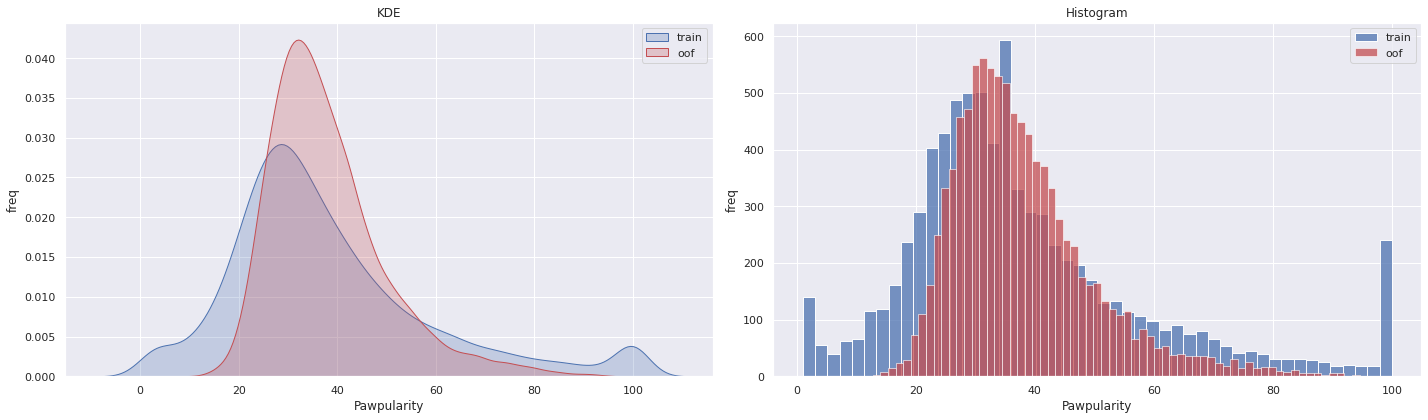

In [29]:
import seaborn as sns
sns.set(style='dark')

plt.figure(figsize=(10*2,6))

plt.subplot(1, 2, 1)
sns.kdeplot(x=train_df[CFG.target_col[0]], color='b',shade=True);
sns.kdeplot(x=df_oof.pred.values, color='r',shade=True);
plt.grid('ON')
plt.xlabel(CFG.target_col[0]);plt.ylabel('freq');plt.title('KDE')
plt.legend(['train', 'oof'])

plt.subplot(1, 2, 2)
sns.histplot(x=train_df[CFG.target_col[0]], color='b');
sns.histplot(x=df_oof.pred.values, color='r');
plt.grid('ON')
plt.xlabel(CFG.target_col[0]);plt.ylabel('freq');plt.title('Histogram')
plt.legend(['train', 'oof'])

plt.tight_layout()
plt.show()

# Submission
This notebook can't be used for submission as this noteboook uses **TPU** which requires `internet access`.

In [30]:
pred_df = pd.DataFrame({'Id':test_df.Id,
                        'Pawpularity':preds.reshape(-1)})
sub_df = pd.read_csv('/kaggle/input/petfinder-pawpularity-score/sample_submission.csv')
del sub_df['Pawpularity']
sub_df = sub_df.merge(pred_df, on='Id', how='left')
sub_df.to_csv('submission.csv',index=False)
sub_df.head(2)

Id  Pawpularity
0  4128bae22183829d2b5fea10effdb0c3    36.873175
1  43a2262d7738e3d420d453815151079e    40.785607

# Remove Files

In [31]:
!rm -r /kaggle/working/wandb

rm: cannot remove '/kaggle/working/wandb': No such file or directory


# Reference:
1. [ViT - Pytorch xla (TPU) for leaf disease](https://www.kaggle.com/mobassir/vit-pytorch-xla-tpu-for-leaf-disease)
2. [baseline solution [LB17.91201]](https://www.kaggle.com/c/petfinder-pawpularity-score/discussion/275094)
3. [RANZCR: EfficientNet TPU Training](https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training)
4. [Triple Stratified KFold with TFRecords](https://www.kaggle.com/cdeotte/triple-stratified-kfold-with-tfrecords)